In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
import tqdm
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import os

modelname="4_28_23_m3"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 embedding_dim: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 n_classes: int):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, embedding_dim)
        #Positional encoding
        self.pos_encode = PositionalEncoding(embedding_dim)

        self.decoder_layers = []

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(embedding_dim, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))
            #Add a feed forward
            layer.append(nn.Linear(embedding_dim, embedding_dim))
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))

            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(embedding_dim, n_classes)
            
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_ff = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_2(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
def tokenize_multi(text_seq: str, features: int, encoding = "utf8") -> torch.Tensor:
    # tokenize the input text
    sentences = []
    for sentence in filter(lambda x: x!="", text_seq.split("\n")):
        base = list(bytes(sentence, "utf8"))
        if len(base) < features:
            base.extend([0] * (features - len(base)))
        tensor = torch.Tensor(base)
        tensor = tensor.unsqueeze(0)
        sentences.append(tensor)

    return torch.cat(sentences, dim = 0)

def tokenize_single(sentence: str, features: int, encoding = "utf8") -> torch.Tensor:
    base = list(bytes(sentence, "utf8"))
    if len(base) < features:
        base.extend([0] * (features - len(base)))
    tensor = torch.Tensor(base)
    return tensor

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], features):
        self.raw_data = data
        self.features = features
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return tokenize_single(self.raw_data[index], self.features)

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode()

In [14]:
n_features = 256 # No. of tokens
n_pad = 512 # Max line length
embedding_dim = 640
batch_size = 48
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
n_layers = 14

In [15]:
path_to_data = "data/reddit_scrape_v4.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\n")))
random.shuffle(data_split)

train_data = data_split[100:]
print(len(train_data))
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

135628


In [16]:
model = Transformer(embedding_dim, head_size, n_features, n_layers, 256)
model=model.to(device)

In [17]:
input=next(testloader_iter)
input=input.to(device)
res = model(input)
print(input.shape)
print(res.shape)
print(res.argmax(-1))

torch.Size([1, 512])
torch.Size([1, 512, 256])
tensor([[165, 127, 127, 254, 127, 147, 108, 254,   4, 187, 254,   4, 254, 232,
         254,  74,  64, 254, 102,  64, 254, 122, 186, 254, 127, 133, 147, 108,
         254,  62, 254, 233, 108, 127, 254,  65, 223, 186,  64, 254,  48, 138,
         254, 122, 117, 122, 254,  24, 254,  54, 108, 127, 238, 254, 243, 232,
         243, 254,  48, 138, 254, 127, 223, 238, 254, 102, 238,  24, 190, 254,
         209, 187, 120, 167,  48, 141, 238, 226, 171, 254, 132, 108,  48,   7,
         238, 254, 254, 254,  36, 165, 254, 209, 238, 254, 127, 186, 102, 141,
         254, 254, 186, 254, 238, 254, 238, 165, 238,  78, 238, 138, 190, 108,
         128, 254, 127, 223, 238, 254, 238, 147, 108, 254,  64, 243, 254, 254,
         238,  54, 108, 243,  45, 254, 127, 243, 254,  78, 232, 138, 238, 254,
         127, 133, 232, 138,  64, 108, 254,  48, 197, 254, 108, 104, 186, 209,
         238, 254, 186, 138, 226, 254, 102, 254, 102,  97,  64, 254, 127, 133,
     

In [18]:
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
n_epochs = 40

In [20]:
!nvidia-smi

Fri Apr 28 22:09:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   49C    P0    63W / 150W |   1493MiB / 23028MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
print(device)

cuda


In [22]:
prompts = [
    "Why does Earth orbit the Sun?",
    "Hello world, ",
    "How to use ChatGPT?",
    "My code does not work. What should I do?",
    "Why is this code not working: `1+\"A\"`?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C?",
    "What is coding?",
]

Epoch 1


100%|██████████| 2826/2826 [51:13<00:00,  1.09s/it]


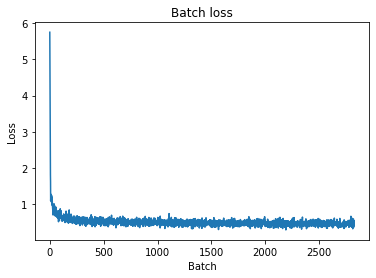

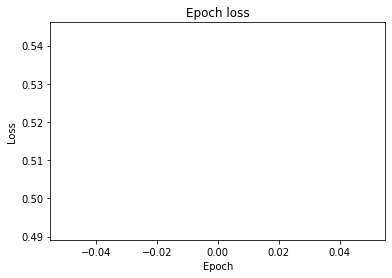

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?

Prompt 1: Hello world, 
Model output: Hello world, athe athe athe athe athe the se athe se an the the the the the the athe the t the the the the the the the the so s sthe the the the se the the the the the the the the the the the the se se there sthe the the sthere the the therere s the s athe se the the the the the the the the the the the the the the the the the the the s in the in the there the the the s s the there there the there the the s the the athe the therererere the there the the the the the there thererere the the the t t t the the t the t the t t the t t the the the the the the there s s the there there the the the there the the theathean there the the the the to the the the the the in s sthere s s s sthere s the there the the s the s the the sthe the the t the s s the the therere the the the the the the the sthe the the the the the so sthe the the the the s the the the in the the the the t

100%|██████████| 2826/2826 [51:23<00:00,  1.09s/it]


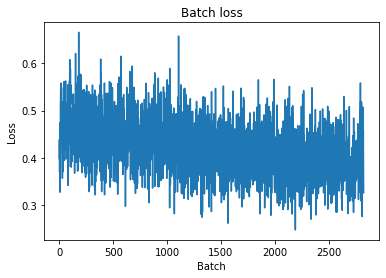

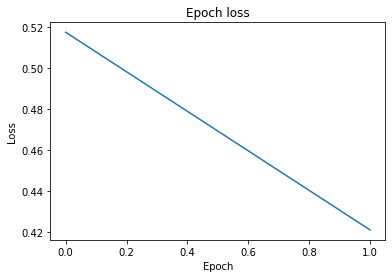

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?

Prompt 1: Hello world, 
Model output: Hello world, you do the and the the and the the are the and the the the and the the and the the the the are the the the are the attt and the the the stat the the the the the sthe the are the the the the sthe are the the the the the sthe are the the sthe are sthe the the the sthe the the the the the the stheathe ttttttttttt in in the is in the the the theathe the the the the the the the are the the the the the the sthe the the there sthe sthere the the the the the the isthe the the the the the the the the the the the the the sthe tthe the sthere the the thererere the the there the the sthe sthere the the sthe the sthe the the the the the the the the the the the the sthe stherere sthe sthe the the the the the in the then the the the the the the sthe there the the the ttthe the ttttthe tthe tthe ttthe tttttthe the tthe the tthe the ttttthe ttttttttthe in tttthe in the

100%|██████████| 2826/2826 [51:23<00:00,  1.09s/it]


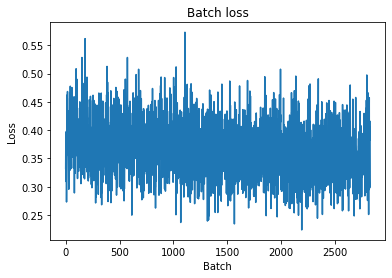

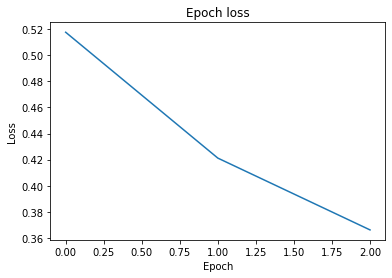

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?

Prompt 1: Hello world, 
Model output: Hello world, I want the the start and the start in the start in the the start and the start and the start and the start in the start a the start and the the start and the the start in the istere and the the start and the the start and the the stare and the the start the the start the the sto the the tope the the the sthe ist in int in thee the the thee the the the the sthe tthe in there in the the the in the the thean the the there the tthe the the the the the the in stherere the the the te toppppppe tttte tte te ttoperere ttttttt in in pperere thererere ttere tere in in tthe therere tere te in terere te in in topere te ttttee the ttope tthe te ton topere the tthererererere there ttin in in the the the therere ttttt there ttte the the t ttttttererererere tin in in tt ttthererererererere ttttttt ttt tttere terererere in tin in tin tin in in in in in in tope tourerer

100%|██████████| 2826/2826 [51:23<00:00,  1.09s/it]


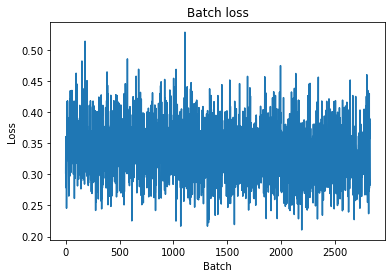

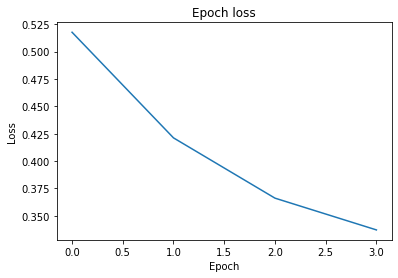

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun? I don't know the statement and in the stated and the start in the start in the start in the conter the conter and the the contice the the compater the the company the the companice the the compater the the compan the completer to the the cand to the the compt to the the the the the coppe to the the the the the copppe top the to the the the the the the the the the the the the copppppp in toppe ttopp top the the tin the topppe to the the the topre tope to tope ttt the topppe to te toppp to top to to there the the the the the the there the the the the the tthe the tere toppppp the the the tin the the the the the the pppppppp ttoppppp ttoppp ttttin tttin t top tin the the the t the ttttttin ttere te tope top t t to topererererere tin tin thererere t tt tterere t topperere tere tte top top top ttin tin te te tin te tin te tere toppe toperere toperen te te pe te tope tope tererereren tten toperen ten ton te t

 26%|██▌       | 725/2826 [13:12<38:10,  1.09s/it]

In [ ]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    for data in tqdm.tqdm(dataloader):
        optimizer.zero_grad()

        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
    
    
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            print(f"Model output: {output}")
            print()



In [ ]:
model = torch.load(prefix_models+"model_E9")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()